# Preparation

In [2]:
import pandas as pd
import os

# check files in dir
print(os.listdir())
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


['test.csv', 'digit-recognizer.ipynb', 'train.csv', 'sample_submission.csv']


# Observation

In [3]:
# check the dataframe profile

# get numbers of row and column
print(train_df.shape)

train_df.head(3)


(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:

print(test_df.shape)

test_df.head(3)


(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# seperate label from train data

train_label = train_df['label']
print('shape of train_label:')
print(train_label.shape)
print(type(train_label))

train_data = train_df.drop(labels='label', axis=1)
print('\nshape of train_data:')
print(train_data.shape)
print(type(train_data))


shape of train_label:
(42000,)
<class 'pandas.core.series.Series'>

shape of train_data:
(42000, 784)
<class 'pandas.core.frame.DataFrame'>


/Users/Eric/.pyenv/versions/3.8.2/envs/venv-kaggle/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Label Number')

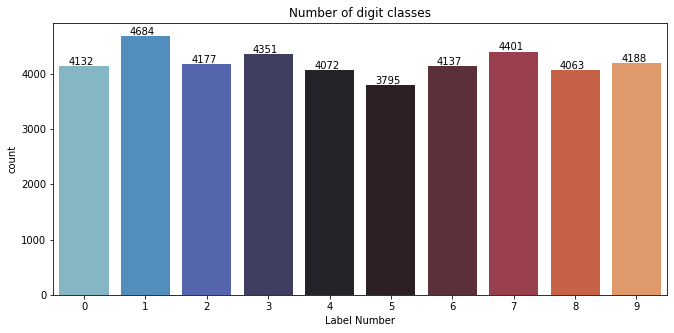

In [9]:
# plot label distribution

import seaborn as sns
import matplotlib.pyplot as plt

# xy ratio of figure
plt.figure(figsize=(11,5)) 

# plot the count of each number and annotate
g = sns.countplot(train_label, palette='icefire')
for label in g.patches:
    g.annotate(label.get_height(), (label.get_x()+0.15, label.get_height()+25))

# other labels
plt.title('Number of digit classes')
plt.xlabel('Label Number')

# label_train.value_counts()


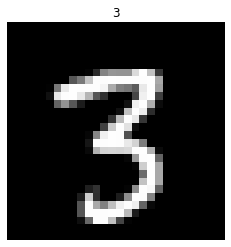

In [10]:
# randomly plot sample image

from random import randrange

idx = randrange(len(train_data))
img = train_data.iloc[idx].values
img = img.reshape(28, 28)

plt.imshow(img, cmap='gray')
plt.title(train_label[idx])
plt.axis('off')
plt.show()


# Preprocessing

In [11]:
# Normalization -> let each pxl value is between 0 and 1
# -> reduce the influence of different illuminations in grayscale
# -> make CNN faster

train_data = train_data / 255.0

test_df = test_df / 255.0


In [12]:
# Reshape -> transform 784 pixels to 28 * 28 * (1 channel) tensor
# a graysacle / black/white image just need one channel

train_data = train_data.values.reshape(-1, 28, 28, 1)
print('shape of train_data: {}'.format(train_data.shape))

test_df = test_df.values.reshape(-1, 28, 28, 1)
print('shape of test_df: {}'.format(test_df.shape))


shape of train_data: (42000, 28, 28, 1)
shape of test_df: (28000, 28, 28, 1)


In [15]:
# Label Encoding
# convert label into one-hot vector (ndarray) -> ease the modelling process

from keras.utils.np_utils import to_categorical
train_label = to_categorical(train_label, num_classes=10)
print(type(train_label))


<class 'numpy.ndarray'>


# Training

In [17]:
# split the train dataset to train and test subsets

from sklearn.model_selection import train_test_split
x_train_data, y_train_data, x_train_label, y_train_label = train_test_split(train_data, train_label, test_size=0.1, random_state=2)

print('shape of x_train_data: {}'.format(x_train_data.shape))
print('shape of y_train_data: {}'.format(y_train_data.shape))
print('shape of x_train_label: {}'.format(x_train_label.shape))
print('shape of y_train_label: {}'.format(y_train_label.shape))


shape of x_train_data: (37800, 28, 28, 1)
shape of y_train_data: (4200, 28, 28, 1)
shape of x_train_label: (37800, 10)
shape of y_train_label: (4200, 10)


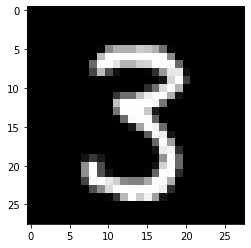

In [18]:
# double check the data for training

plt.imshow(x_train_data[555][:,:,0], cmap='gray')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

# convolutional layer 1
# -> set bigger size of kernel (receptive field) to include more feature info for each neuron
# -> apply max pooling to downsample by keeping the max sample of each pool to improve performange and reduce over-fitting
# -> apply dropout after pooling to reduce over-fitting
model.add(Conv2D(filters = 8, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# convolutional layer 2
# -> apply more filters to recognize feature
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))


In [21]:
# define optimizer

optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)


/Users/Eric/.pyenv/versions/3.8.2/envs/venv-kaggle/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# compile the model

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [23]:
# reference to https: // stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

epochs = 10
batch_size = 250


In [24]:
# data augmentation

datagen = ImageDataGenerator(
    featurewise_center = False, # set input mean to 0 over the dataset
    samplewise_center = False, # set each sample mean to 0
    featurewise_std_normalization = False, # divide inputs by std of the dataset
    zca_whitening = False, # dimension reduction
    rotation_range = 5, # randomly rotate images in the range 5 degrees
    zoom_range = 0.1, # randomly zoom image 10%
    width_shift_range = 0.1, # randomly shift images horizontally 10%
    height_shift_range = 0.1, # randomly shift images veritically 10%
    horizontal_flip = False, # randomly flip images
    vertical_flip = False) # randomly flip images

datagen.fit(x_train_data)

In [25]:
# fit the model

history = model.fit_generator(
    datagen.flow(x_train_data, x_train_label, batch_size = batch_size), 
    epochs = epochs,
    validation_data = (y_train_data, y_train_label), 
    steps_per_epoch=x_train_data.shape[0] // batch_size)


Epoch 1/10


/var/folders/0d/plk_tk5d3mg9zdgr60cdc90w0000gn/T/ipykernel_3881/2597117698.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


151/151 [==============================] - 11s 73ms/step - loss: 1.1034 - accuracy: 0.6283 - val_loss: 0.2350 - val_accuracy: 0.9343
Epoch 2/10
151/151 [==============================] - 11s 73ms/step - loss: 0.4518 - accuracy: 0.8564 - val_loss: 0.1381 - val_accuracy: 0.9574
Epoch 3/10
151/151 [==============================] - 11s 71ms/step - loss: 0.3325 - accuracy: 0.8956 - val_loss: 0.1048 - val_accuracy: 0.9690
Epoch 4/10
151/151 [==============================] - 11s 72ms/step - loss: 0.2720 - accuracy: 0.9147 - val_loss: 0.0885 - val_accuracy: 0.9740
Epoch 5/10
151/151 [==============================] - 11s 72ms/step - loss: 0.2417 - accuracy: 0.9266 - val_loss: 0.0834 - val_accuracy: 0.9757
Epoch 6/10
151/151 [==============================] - 11s 74ms/step - loss: 0.2208 - accuracy: 0.9307 - val_loss: 0.0743 - val_accuracy: 0.9760
Epoch 7/10
151/151 [==============================] - 11s 73ms/step - loss: 0.2044 - accuracy: 0.9381 - val_loss: 0.0710 - val_accuracy: 0.9802
Epo

# Evaluation

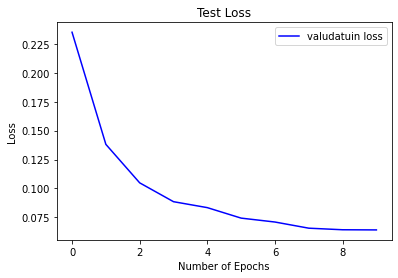

In [26]:
# plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color = 'b', label = 'valudatuin loss')
plt.title('Test Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

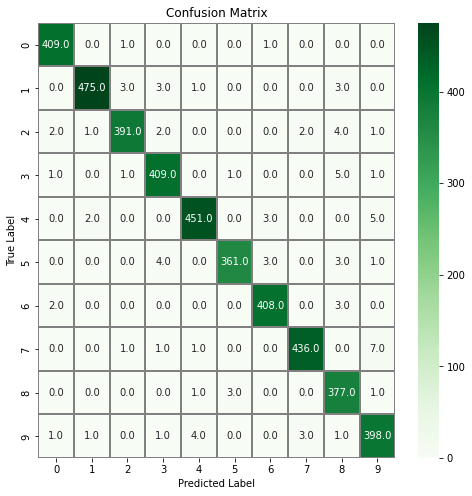

In [27]:
# confusion matrix

import numpy as np

# Predict the values from the validation dataset
Y_pred = model.predict(y_train_data)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_train_label, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,
            cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
